**Testing BOTorch implementation of Dirichlet-based GP classification on Toy dataset**

In [15]:
import torch
import botorch
import pandas as pd
import matplotlib.pyplot as plt
import gpytorch

In [2]:
from botorch.models.gp_regression import SingleTaskGP
dtype=torch.double

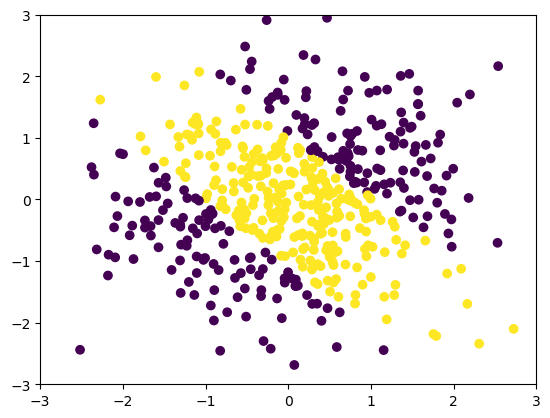

In [33]:
def gen_data(num_data, seed = 2024):
    torch.random.manual_seed(seed)

    x = torch.randn(num_data,1)
    y = torch.randn(num_data,1)

    u = torch.rand(1)
    data_fn = lambda x, y: torch.cos(x)*torch.cos(y) - torch.sin(x)*torch.sin(y)
    latent_fn = data_fn(x, y)
    z = torch.heaviside(latent_fn - 0.5, torch.zeros(latent_fn.shape)).long().squeeze()
    return torch.cat((x,y),dim=1), z, data_fn

train_x, train_y, genfn = gen_data(500)

plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y) 
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

In [36]:
import numpy as np
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
# test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_latent  = genfn(test_x_mat, test_y_mat)
test_labels = torch.heaviside(test_latent - 0.5, torch.zeros(test_latent.shape))
test_y = test_labels.view(-1)

In [64]:
te_x = torch.zeros((2, 400, 2), dtype=dtype)
te_x[:, :, 0] = test_x.T
te_x[:, :, 1] = test_x.T

In [39]:
from gpytorch.likelihoods import DirichletClassificationLikelihood
dir_likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=False, alpha_epsilon=1e-2)

In [45]:
tr_targets = torch.zeros((2, 500, 1), dtype=dtype)
tr_targets[:, :, 0] = dir_likelihood.transformed_targets.double()

tr_x = torch.zeros((1, 500, 2), dtype=dtype)
tr_x[0, :, :] = train_x

In [46]:
from botorch.models.transforms import Standardize, Normalize

cls_model = SingleTaskGP(train_X=tr_x, train_Y=tr_targets, likelihood=dir_likelihood)

/Users/gouravkumbhojkar/miniconda3/envs/botorch/lib/python3.11/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/gouravkumbhojkar/miniconda3/envs/botorch/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([[-3.8076],
        [-3.4392]], dtype=torch.float64), std = tensor([[3.2874],
        [3.2874]], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [47]:
training_iter = 50
# train model
cls_model.train()
dir_likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(cls_model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(dir_likelihood, cls_model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = cls_model(tr_x)
    # Calc loss and backprop gradients
    loss = -mll(output, dir_likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f' % (
            i + 1, training_iter, loss.item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 4.035
Iter 6/50 - Loss: 3.824
Iter 11/50 - Loss: 3.684
Iter 16/50 - Loss: 3.594
Iter 21/50 - Loss: 3.538
Iter 26/50 - Loss: 3.503
Iter 31/50 - Loss: 3.481
Iter 36/50 - Loss: 3.467
Iter 41/50 - Loss: 3.458
Iter 46/50 - Loss: 3.451


In [65]:
cls_model.eval()
dir_likelihood.eval()

with torch.no_grad():
    posterior = cls_model.posterior(te_x, batch_shape=tr_targets.shape[:-2])
    logit_mean = posterior.mean
    logit_std = posterior.stddev

In [67]:
pred_samples = posterior.sample(torch.Size((256,))).exp()
prob = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

/Users/gouravkumbhojkar/miniconda3/envs/botorch/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


**Not successful**